In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
reddit = pd.read_csv("Reddit_Combi.csv", sep=';')
reddit.drop(['Unnamed: 4'], axis=1, inplace=True)
reddit.head()

,title,body,Body_Title,label
0,Envy to other is swallowing me,"Im from developingcountry, Indonesia , and for...",Envy to other is swallowing me Im from develop...,1
1,Nothin outta the ordinary. Paradise. Job stres...,Um hello ....well many can relate im sure. Aft...,Nothin outta the ordinary. Paradise. Job stres...,1
2,Almost 49 and the chasm of emptiness has never...,I’ve been diagnosed severe bi polar where you ...,Almost 49 and the chasm of emptiness has never...,1
3,I’m happy again,"After my closest friend left me in April, I ha...",I’m happy again After my closest friend left m...,0
4,Is it possible to recover from such a traumati...,"I am only 15, and yet I feel my life is alread...",Is it possible to recover from such a traumati...,1


In [3]:
print(reddit.shape)
reddit.isnull().sum()

(3123, 4)


title          0
body          10
Body_Title     0
label          0
dtype: int64

In [4]:
twitter = pd.read_csv("Twitter_ Non-Advert-Tabelle 1.csv", sep=';')
twitter.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
twitter.head()

,text,label
0,speak-no-evil monkey Can I Be Honest With You...,1
1,Frau Goebbels early signs of psychosis psychot...,1
2,A lot of work and unfulfilled tasks plunge you...,1
3,Private health insurance delivers value for yo...,1
4,XpertOnline offers you the convenience of view...,1


In [5]:
print(twitter.shape)
twitter.isnull().sum()

(2051, 2)


text     0
label    0
dtype: int64

In [6]:
df = pd.DataFrame({
    'text': np.append(reddit['Body_Title'], twitter['text']),
    'label': np.append(reddit['label'], twitter['label'])
})
df.head()

,text,label
0,Envy to other is swallowing me Im from develop...,1
1,Nothin outta the ordinary. Paradise. Job stres...,1
2,Almost 49 and the chasm of emptiness has never...,1
3,I’m happy again After my closest friend left m...,0
4,Is it possible to recover from such a traumati...,1


In [7]:
print(df.shape)
df.isnull().sum()

(5174, 2)


text     0
label    0
dtype: int64

In [8]:
df.duplicated().sum()

79

In [9]:
df.drop_duplicates(keep="first", inplace=True)
df.shape

(5095, 2)

In [10]:
df.reset_index(drop=True, inplace=True)

In [11]:
label0 = df[df['label'] == 0].copy()
label1 = df[df['label'] == 1].copy()
print(len(label0), len(label1))

1138 3957


In [12]:
label0.reset_index(drop=True, inplace=True)
label1.reset_index(drop=True, inplace=True)

# Function Declaration

In [13]:
import random
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import nltk
import string
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

model = SVC(class_weight="balanced")

In [14]:
def is_picked(index, num):
    if index in num:
        return 1
    else:
        return 0

In [15]:
nltk.download('stopwords')
nltk.download('punkt')

ps = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nico\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nico\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [16]:
def txt_transform(text):
    text = text.lower()
    
    text = nltk.word_tokenize(text)
    
    # Removing special characters, stop words, and punctuations
    cleaned = []
    for i in text:
        if i.isalnum() and i not in stopwords.words('english') and i not in string.punctuation:
            cleaned.append(i)
    
    stemmed = []
    for i in cleaned:
        stemmed.append(ps.stem(i))
    
    # Sentiment Analysis then return
    return " ".join(stemmed)

# Data Collection

In [33]:
sample_ratio = np.arange(1.5, 3, 0.1)
loop = 25

accuracy = []
precision_0 = []
recall_0 = []
f1_0 = []
precision_1 = []
recall_1 = []
f1_1 = []

In [34]:
for i in sample_ratio:
    num = []
    sample_size = round(len(label0)*i)
    num = random.sample(range(len(label1)), sample_size)
    label0['picked'] = 1
    label1['picked'] = label1.index.map(lambda x: is_picked(x, num))
    df = pd.concat([label0, label1[label1['picked']==1]]).reset_index(drop=True)
    
    df['transformed'] = df['text'].apply(txt_transform)
    xdata = tfidf.fit_transform(df['transformed'])
    ydata = df['label']
    
    acc = 0
    p0 = 0
    r0 = 0
    f0 = 0
    p1 = 0
    r1 = 0
    f1 = 0
    
    for j in range(loop):
        xtrain, xtest, ytrain, ytest = train_test_split(xdata, ydata, train_size=0.7)
        model.fit(xtrain, ytrain)
        pred = model.predict(xtest)
        
        acc += accuracy_score(pred, ytest)
        
        p0 += precision_score(pred, ytest, pos_label=0)
        r0 += recall_score(pred, ytest, pos_label=0)
        f0 += f1_score(pred, ytest, pos_label=0)
        
        p1 += precision_score(pred, ytest, pos_label=1)
        r1 += recall_score(pred, ytest, pos_label=1)
        f1 += f1_score(pred, ytest, pos_label=1)
    
    accuracy.append(acc/loop)
    
    precision_0.append(p0/loop)
    recall_0.append(r0/loop)
    f1_0.append(f0/loop)
    
    precision_1.append(p1/loop)
    recall_1.append(r1/loop)
    f1_1.append(f1/loop)

# Plotting

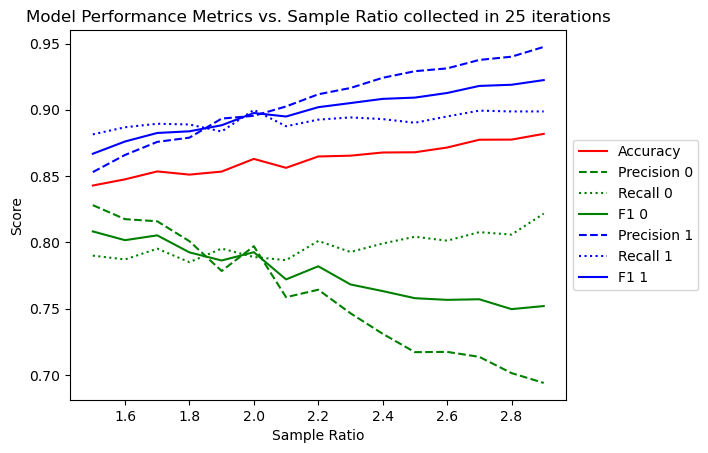

In [35]:
plt.plot(sample_ratio, accuracy, 'r',label = "Accuracy")

plt.plot(sample_ratio, precision_0, 'g--',label = "Precision 0")
plt.plot(sample_ratio, recall_0, 'g:',label = "Recall 0")
plt.plot(sample_ratio, f1_0, 'g',label = "F1 0")

plt.plot(sample_ratio, precision_1, 'b--',label = "Precision 1")
plt.plot(sample_ratio, recall_1, 'b:',label = "Recall 1")
plt.plot(sample_ratio, f1_1, 'b',label = "F1 1")

plt.title(f'Model Performance Metrics vs. Sample Ratio collected in {loop} iterations')
plt.xlabel('Sample Ratio')
plt.ylabel('Score')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()